In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in range(len(FPR)-1):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

In [3]:
FN

NameError: name 'FN' is not defined

In [4]:
def get_ROC_curve(folder, threshold, eval_df):
    TPR, FPR = [], []
    P=len(eval_df)
    N=0
    thresh=0
    eval_df=eval_df.reset_index()
    for file in os.listdir(folder):
        N+=len(pd.read_csv(folder+file, sep=';'))
    N=N-P 
    for rel_err in threshold:   
        TP=0
        FP=0
        for i in range(len(eval_df)):
            df = pd.read_csv(folder+'proj_morg_'+eval_df.Name[i]+'.csv', sep=';')
            RT_true = eval_df.RT[i]
            
            
            rt_range = [eval_df.RT[i]*(1-rel_err/100), eval_df.RT[i]*(1+rel_err/100)]
            #print(eval_df.Name[i])
            TP_pred_rt = df[df.inchi == eval_df.InChI[i]]['Projected_RT'].values[0]
            if TP_pred_rt>=rt_range[0] and TP_pred_rt<=rt_range[1]:
                TP+=1
                
          #  if TP_pred_rt*(1+rel_err/100)>=RT_true and TP_pred_rt*(1-rel_err/100)<=RT_true:
          #      TP+=1 
          #  FP+=len(df[(df.Projected_RT*(1+rel_err/100)>=RT_true)&(df.Projected_RT*(1-rel_err/100)<=RT_true)])  
            FP+=len(df[(df.Projected_RT<=rt_range[1])&(df.Projected_RT>=rt_range[0])])  
            

        
        TPR.append(TP/P)
        FPR.append(FP/N)
        if thresh==0 and TP/P>0.8:
            thresh=rel_err
    #print (P, N)
        #if len(TPR)>1:
            #if TPR[len(TPR)-2]<TPR[len(TPR)-1]:
                #thresh=rel_err
            
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))], thresh)
        
            
            
            

In [5]:
threshold=np.arange(0, 200, 2.5)

In [115]:
#here we calculate ROC curves for each dataset
sets = ['nanoHPLC', 'Bade_Publi', 'RPMMFDA', 'RPFDAMM', 'Eawag_XBridgeC18']
ROC_curves = {}
thresh=0
for ds in sets:
    print (ds)
    proj_dir = '../data/projections/isomers/'+ds+'/'
    eval_df = pd.read_csv('../data/eval_sets/unique_'+ds + '.csv', sep=';')
    TPR, FPR, thresh, t = get_ROC_curve(proj_dir, threshold, eval_df)
    ROC_curves[ds] = (TPR, FPR, thresh, t)
    

nanoHPLC
Best threshold: 27.5
Bade_Publi
Best threshold: 30.0
RPMMFDA
Best threshold: 25.0
RPFDAMM
Best threshold: 12.5
Eawag_XBridgeC18
Best threshold: 42.5


In [116]:
for ds in sets:
    print(ROC_curves[ds][3])

22.5
45.0
35.0
37.5
50.0


In [130]:
#here we calculate the number of total and filtered candidates for each compound in each dataset
T, F, FN, RF ={}, {}, {},{}
for ds in sets:
    proj_dir = '../data/projections/isomers/'+ds+'/'
    eval_df = pd.read_csv('../data/eval_sets/unique_'+ds + '.csv', sep=';')
    rel_err= ROC_curves[ds][3]
    total, filtered, rel_filtered=[],[], []
    TP=0
    for i in range(len(eval_df)):
            df = pd.read_csv(proj_dir+'proj_morg_'+eval_df.Name[i]+'.csv', sep=';')
            RT_true = eval_df.RT[i]
            total.append(len(df))
            rt_range = [eval_df.RT[i]*(1-rel_err/100), eval_df.RT[i]*(1+rel_err/100)]
            
            TP_pred_rt = df[df.inchi == eval_df.InChI[i]]['Projected_RT'].values[0]
            if TP_pred_rt>=rt_range[0] and TP_pred_rt<=rt_range[1]:
                TP+=1
            filtered.append(len(df[(df.Projected_RT<=rt_range[1])&(df.Projected_RT>=rt_range[0])]))
            rel_filtered.append(100*len(df[(df.Projected_RT<=rt_range[1])&(df.Projected_RT>=rt_range[0])])/len(df))
    T[ds] = total
    F[ds] = filtered
    RF[ds] = rel_filtered
    FN[ds] = len(eval_df)-TP

In [131]:
import statistics as st
import matplotlib

58.53140899619024
71.99115933211883
72.48139148757926
75.11429696256347
67.76829100354806


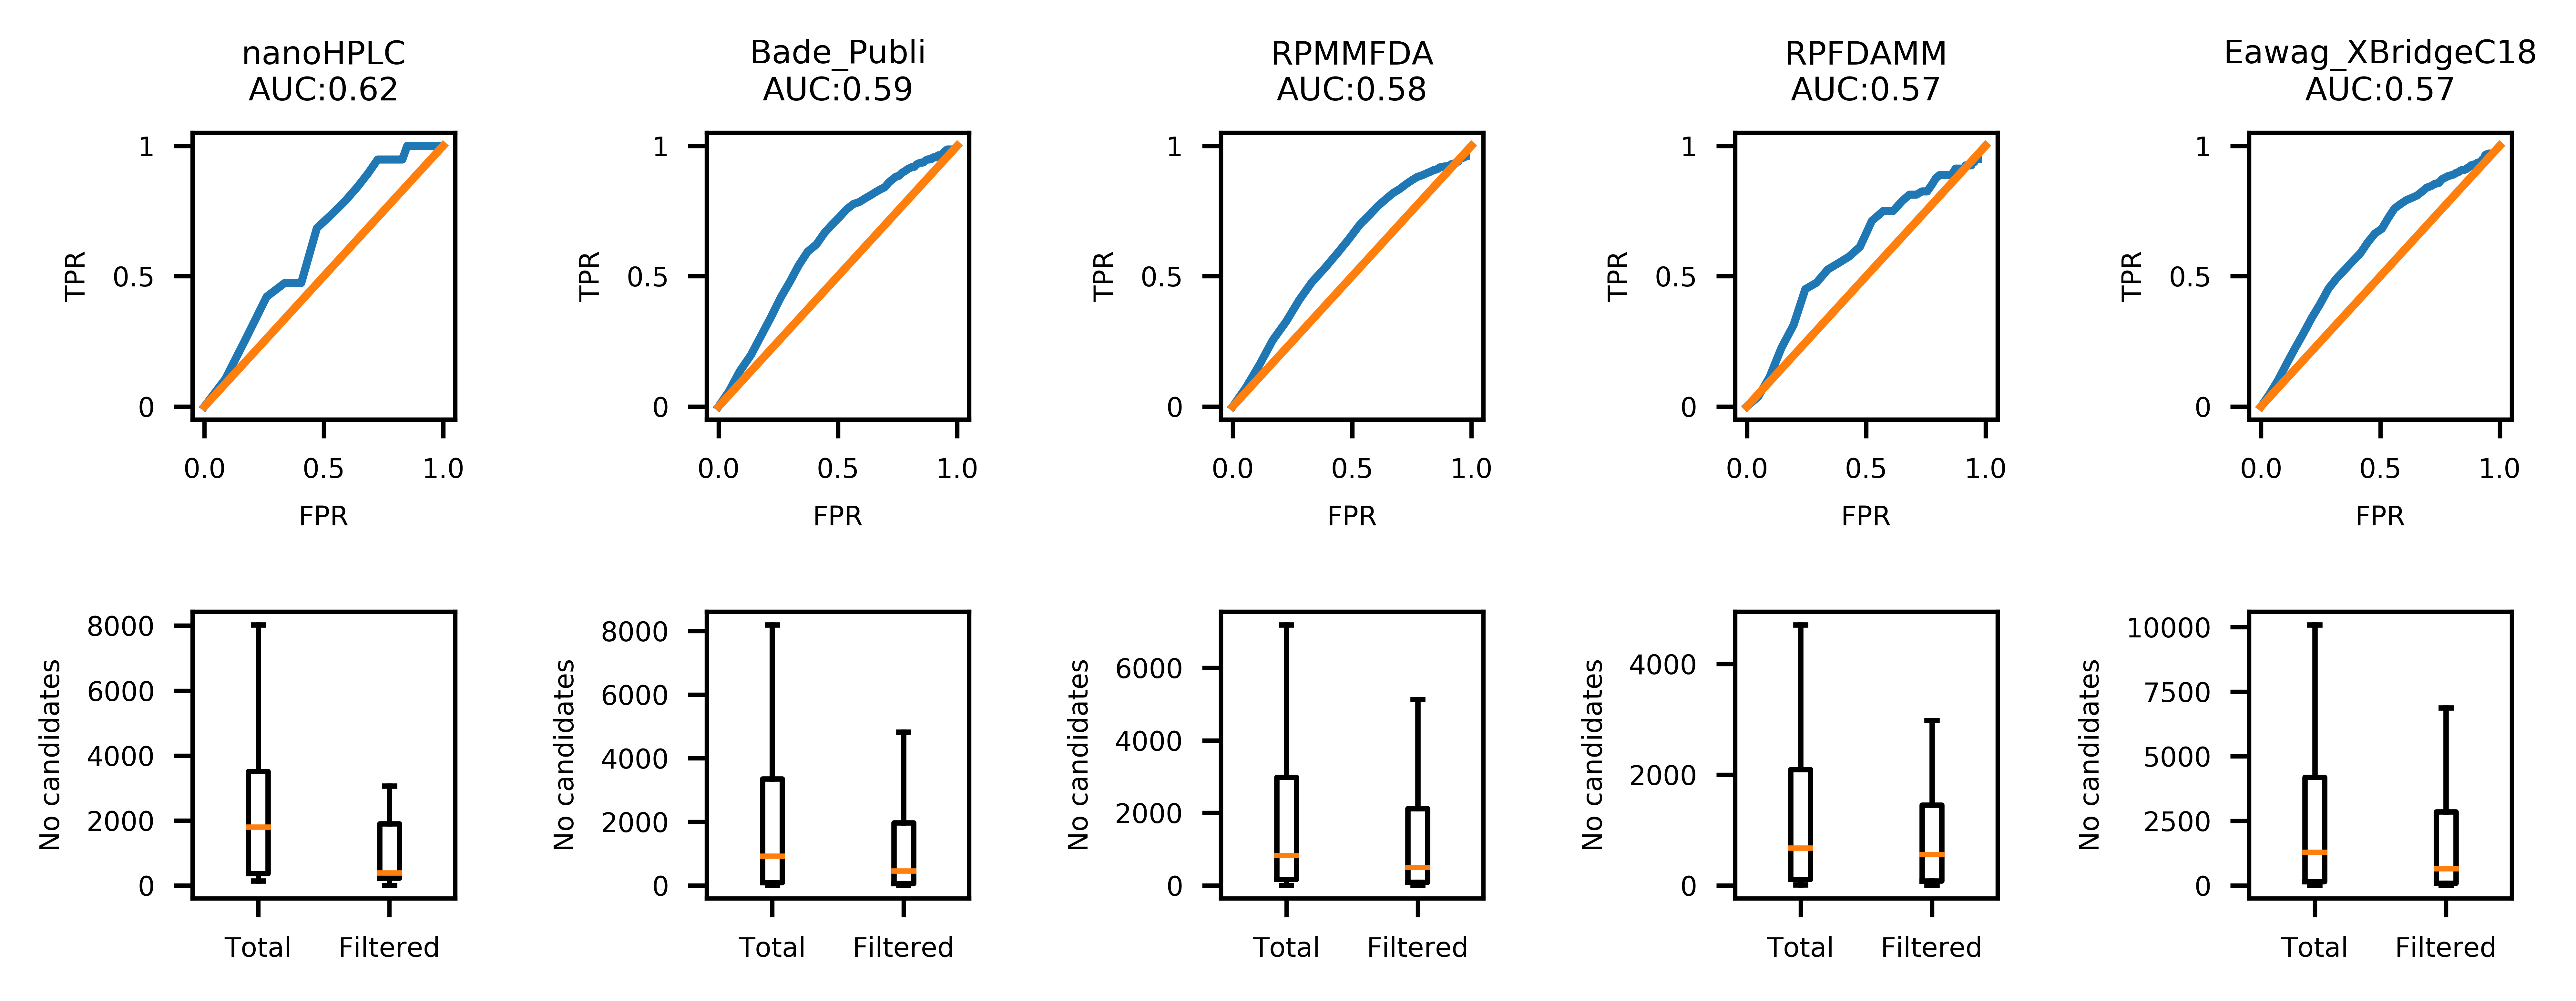

In [134]:
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(2, 5, figsize=(6.85, 2.8), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 5})
for ds in sets:   
    print(st.mean(RF[ds]))
    axs[0,i].plot(ROC_curves[ds][1], ROC_curves[ds][0])
    axs[0,i].plot(x,y)
    axs[0,i].set_yticks([0,0.5, 1])
    axs[0,i].set_xlabel('FPR')
    axs[0,i].set_ylabel('TPR')
    axs[0,i].set_yticklabels(['0', '0.5', '1'])
    axs[0,i].set_title(ds+'\n'+'AUC:'+'%.2f'%(ROC_AUC(ROC_curves[ds][0], ROC_curves[ds][1])))
    
    
    
    axs[1,i].boxplot((T[ds], F[ds]), showfliers=False)
    axs[1,i].set_xticklabels(labels, fontsize=5)
    axs[1,i].set_ylabel('No candidates')
    i+=1
    fig.tight_layout(pad=3.0)
    
    


In [34]:
df_min = pd.read_csv(proj_dir+'proj_morg_Oxymetazoline.csv', sep=';')
df_max = pd.read_csv(proj_dir+'proj_morg_Acetaminophen.csv', sep=';')

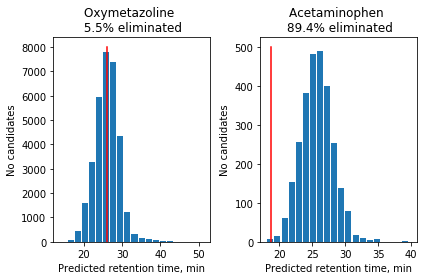

In [56]:
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)
n_bins=20
x_min=[25.99, 25.99]
y_min = [0, 8000]
x_max=[18.67, 18.67]
y_max = [0, 500]
# We can set the number of bins with the `bins` kwarg
axs[0].hist(df_min.Projected_RT, bins=n_bins, width=1.6)
axs[0].plot(x_min, y_min, color='red')
axs[0].set_title('Oxymetazoline \n 5.5% eliminated')
axs[1].set_title('Acetaminophen \n 89.4% eliminated')
for ax in axs:
    ax.set_ylabel('No candidates')
    ax.set_xlabel('Predicted retention time, min')

axs[1].hist(df_max.Projected_RT, bins=n_bins, width=0.9)
axs[1].plot(x_max, y_max, color = 'red')